# Projeto 1

Aluno: <span style="color:red">Luca Mizrahi</span>

Entrega: 16 de maio de 2024

Neste projeto você vai construir um modelo de regressão sobre um dataset de notas finais de alunos do ensino fundamental em relação a parâmetros socio-ambientais dos mesmos. O dataset foi obtido de 
https://archive.ics.uci.edu/dataset/320/student+performance.

## Descrição do projeto

O projeto tem duas partes: modelagem inicial, e modelo com filtragem dos dados.

### Fase 1 

Na parte inicial, você deverá:

- Realizar *feature engineering* conforme necessário
    - Por exemplo: codificar as variáveis categóricas com `OneHotEncoding`
    - Não remova *outliers* aqui: faremos isso na seção seguinte
- Construir três modelos de regressão:
    - Um modelo usando o regressor `DummyRegressor` do scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) que vai servir de "regressor trivial" para nós.
    - Um modelo `Ridge`.
    - Um outro modelo qualquer à sua escolha.
    Como o professor é santo, os dois primeiros já estão implementados para você! Então só falta escolher o terceiro.
- Fazer o ajuste de hiperparâmetros dos modelos. O código de exemplo já mostra como fazer o ajuste dos modelos iniciais, você especifica o grid de parâmetros de teste para o seu terceiro modelo.
- Comparar os desempenhos de modelos de modo adequado. Estude o material em https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html para saber como fazer o teste t com compensação de correlação dos desempenhos dos modelos em um cenário de validação cruzada.
- Escolhido o melhor modelo, treiná-lo no conjunto de treinamento e medir o desempenho no
conjunto de teste, para estimar o desempenho de generalização do modelo.
- Escrever suas conclusões à respeito do que foi aprendido acerta do modelo, por exemplo:
    - Quais as consequências do desempenho do modelo final para a estimação das notas finais?
    - Quais features são mais importantes na determinação da estimativa da nota final? Note que essa pergunta pode ou não ter resposta, dependendo das capacidades dos modelos de regressão que você escolher.

### Fase 2

Agora execute uma filtragem dos dados de treinamento para remover valores anormais. Por exemplo:

- Remova os alunos que tiveram nota final zero
- Remova os alunos que faltaram muito - defina você mesmo o que é "faltar muito"

Refaça o processo da fase 1 para esses dados filtrados.

### Rubrica

Os itens a serem avaliados no projeto são:

FEAT – Fazer feature engineering adequadamente

HYPER – Para cada modelo, fez ajuste de hiperparâmetros adequadamente

MODEL – Treinou e comparou adequadamente os modelos para selecionar o melhor modelo

PERF – Análise de desempenho do modelo. NÃO SERÁ EXIGIDA NENHUMA PERFORMANCE ESPECÍFICA, ISTO NÃO É UMA COMPETIÇÃO DE DESEMPENHO.

FILT - Executar a fase 2: filtragem de dados adequada e repetição do experimento.

- I – Insuficiente

    - Não entregou, ou entregou abobrinha

- D – Em desenvolvimento

    - Faltou um de FEAT, MODEL, PERF

- C – Minimo aceitável

    - Fez FEAT, MODEL, PERF

- B – Esperado

    - Fez FEAT, HYPER, MODEL, PERF

- A – Excepcional

    - Fez FEAT, HYPER, MODEL, PERF, FILT


# Inicio do projeto

## Leitura dos dados e correção de tipos de dados

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATA_DIR = Path.cwd()

In [3]:
def load_data(data_dir: Path = DATA_DIR) -> pd.DataFrame:
    # Read data and fix column types.
    df = pd.read_csv(data_dir / 'data.csv')

    categorical_columns = [
        'school',
        'sex',
        'address',
        'famsize',
        'Pstatus',
        'Mjob',
        'Fjob',
        'reason',
        'guardian',
        'schoolsup',
        'famsup',
        'paid',
        'activities',
        'nursery',
        'higher',
        'internet',
        'romantic',
    ]
    numerical_columns = [
        'age',
        'absences',
        'grade',
    ]
    ordinal_columns = [
        'Medu',
        'Fedu',
        'traveltime',
        'studytime',
        'failures',
        'famrel',
        'freetime',
        'goout',
        'Dalc',
        'Walc',
        'health',
    ]
    for column_group, column_type in (
        (categorical_columns, 'category'),
        (numerical_columns, 'float64'),
        (ordinal_columns, 'int64'),
    ):
        for column in column_group:
            df[column] = df[column].astype(column_type)

    # Split features and target, and return.
    X = df.drop(columns=['grade']).copy()
    y = df['grade'].copy()
    return X, y

In [4]:
X, y = load_data()

## Visualização simples dos dados

Chamar isso de análise exploratória é vexatório...

In [5]:
def make_barplots(X: pd.DataFrame, y: pd.Series) -> None:
    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, (column_name, column_series) in enumerate(X.items()):
        column_series \
            .value_counts() \
            .sort_index(ascending=False) \
            .plot \
            .barh(ax=axes[index])
        axes[index].set_title(column_name)

    fig.suptitle('Barplots of Categorical and Ordinal Features', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

    plt.figure(figsize=(3, 4))
    y.plot.hist(bins=20, edgecolor='black')
    plt.title('Histogram of Target')
    plt.show()
    

In [6]:
def make_boxplots(X: pd.DataFrame, y: pd.Series) -> None:
    df = pd.concat([X, y], axis=1)

    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, column in enumerate(X.columns):
        ax = axes[index]
        bp_objs = df.boxplot(
            by=['school', column],
            column='grade',
            ax=ax,
            rot=45,
            fontsize=8,
            return_type='dict',
            patch_artist=True,
        )
        boxes = bp_objs['grade']['boxes']
        box_colors = [
            'lightgreen' if '(GP,' in tick.get_text() else 'lightblue'
            for tick in ax.get_xticklabels()
        ]
        for box, color in zip(boxes, box_colors):
            box.set_facecolor(color)
        ax.set_title(column)
        ax.set_xlabel('')
    fig.suptitle('Grade distribution by feature and school', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

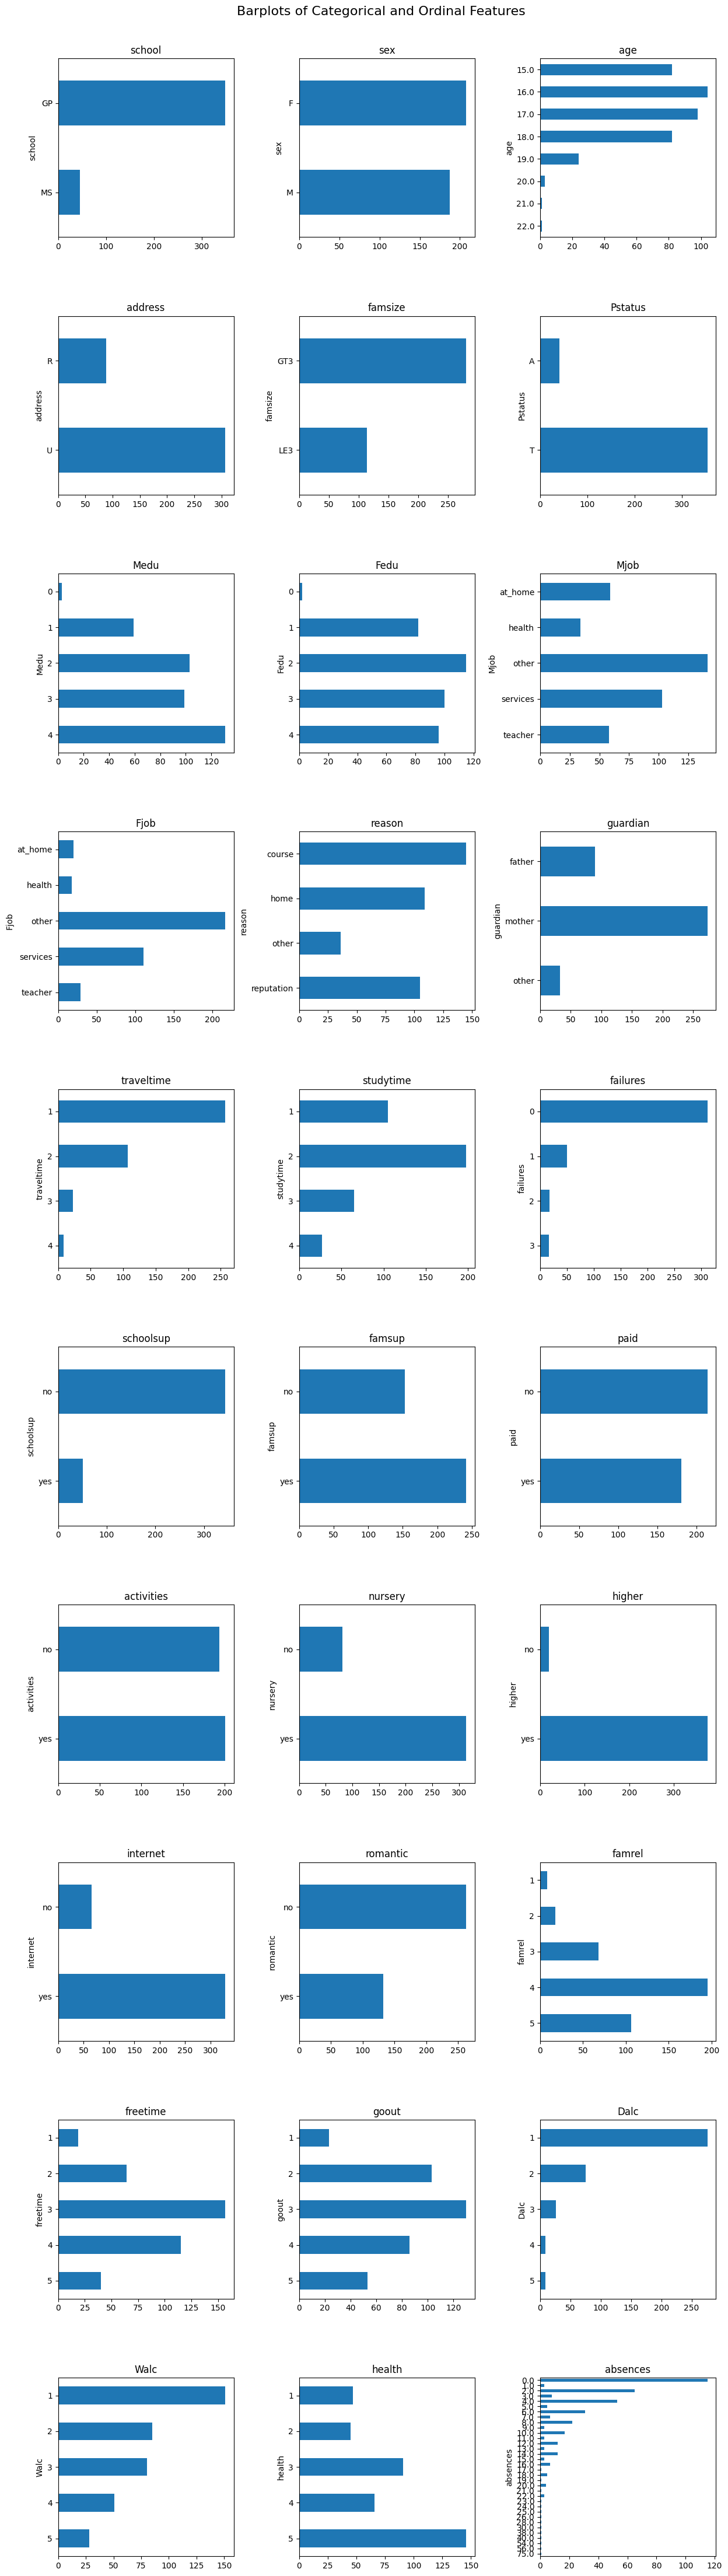

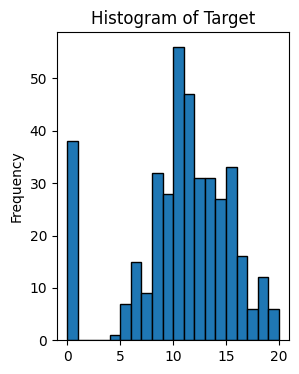

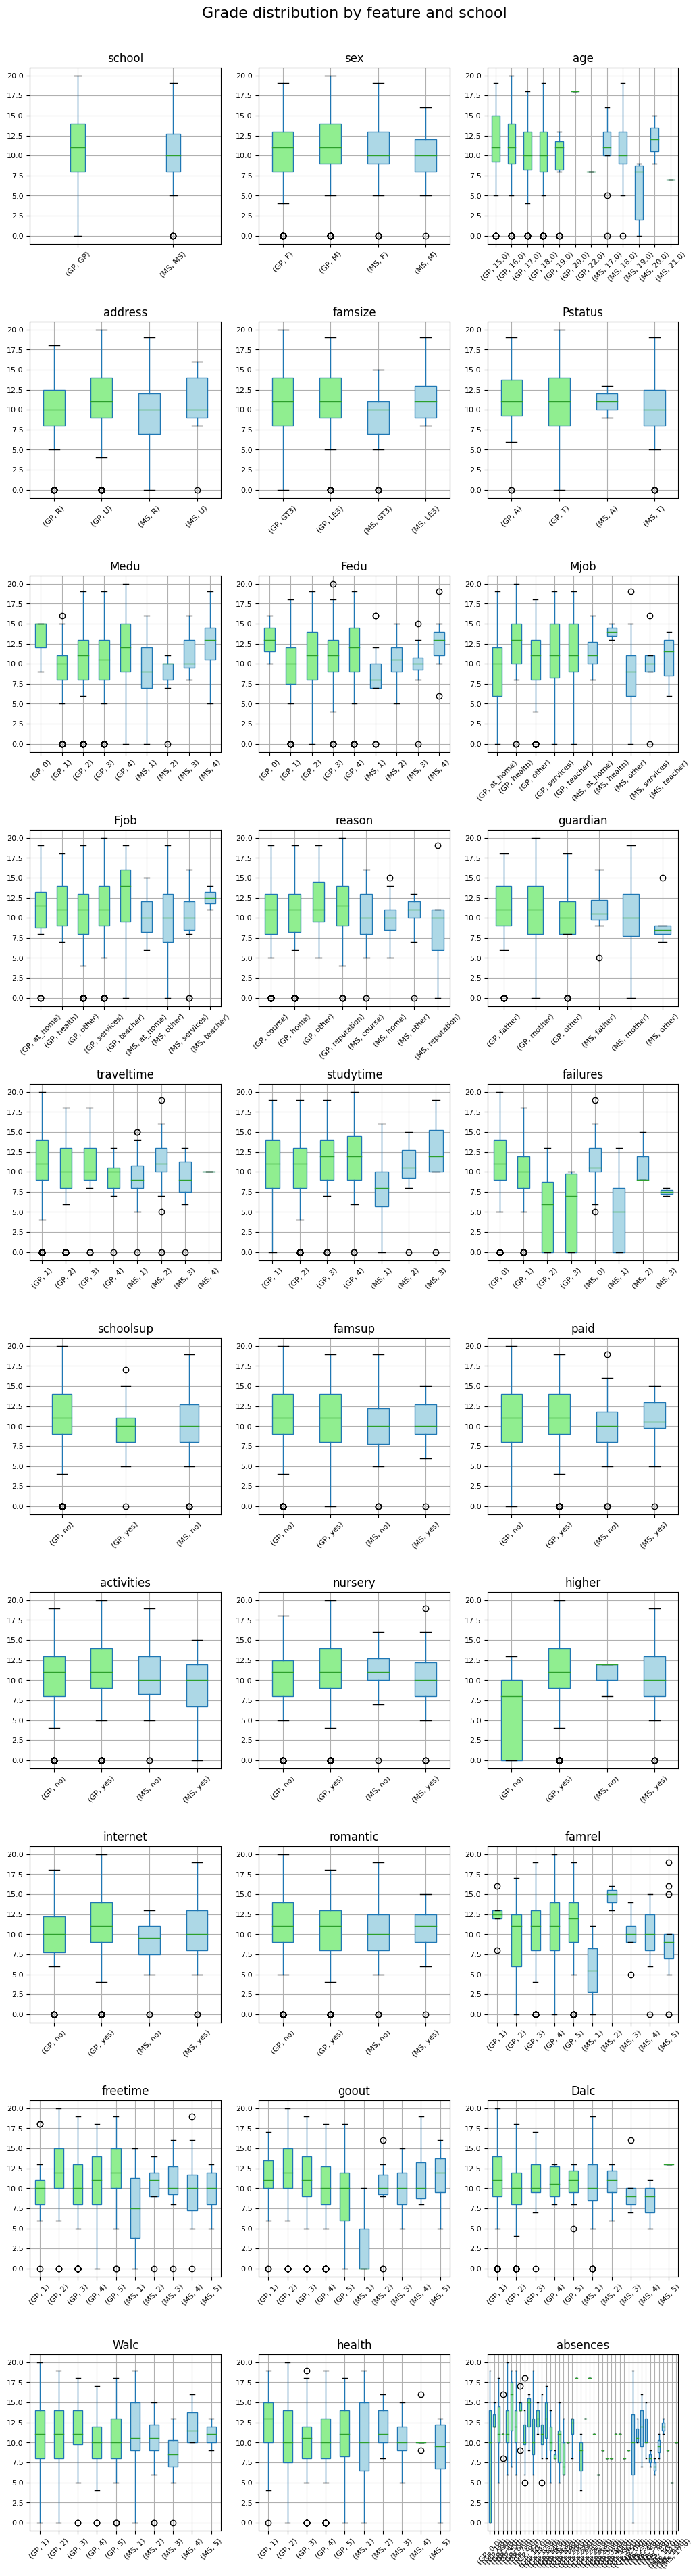

In [7]:
make_barplots(X, y)
make_boxplots(X, y)

## Separação treino-teste e modelagem inicial

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [12]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer

In [13]:
categorical_features = X.select_dtypes(include=['category']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    # Outros passos que podem ser adicionados aqui?
    # ('outlier_remover', OutlierRemover()), # Exemplo de um passo que poderia ser adicionado
    # O que mais pode ir aqui?
    
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', DummyRegressor(strategy='mean')),
])

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Quanto maior o numero de splits, maior a significância estatística da
# validação cruzada, mas também maior o tempo de execução.
num_splits = 1000

param_grid = [
    {
        'regressor': [DummyRegressor(strategy='mean')],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': np.logspace(-3, 3, 7),
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200, 500],
        'regressor__max_depth': [5, 10, None],
    },
]

test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)
grid.fit(X_train, y_train)

# Exibindo o melhor modelo encontrado
print(f'Melhor modelo: {grid.best_estimator_}')

In [ ]:
results_df = pd.DataFrame(grid.cv_results_) \
    .sort_values(by='rank_test_score')

results_df = results_df \
    .set_index(
        results_df["params"] \
            .apply(lambda x: "_".join(str(val) for val in x.values()))
    ) \
    .rename_axis("model")

model_scores = results_df.filter(regex=r"split\d*_test_score")

In [ ]:
model_scores.index[0]

In [ ]:
mean_perf = model_scores.agg(['mean', 'std'], axis=1)
mean_perf['std'] = mean_perf['std'] / np.sqrt(num_splits)
mean_perf = mean_perf.sort_values('mean', ascending=False)
mean_perf

## Comparação de modelos

O código a seguir foi copiado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [ ]:
import numpy as np

from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [ ]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}")

In [ ]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [ ]:
pairwise_comp_df

In [ ]:
for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores

    name_i = model_scores.index[model_i]
    name_best = model_scores.index[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(model_i_scores, bins=30, alpha=0.5, label=name_i)
    plt.hist(best_model_scores, bins=30, alpha=0.5, label=name_best)
    plt.title(f'{name_i} vs {name_best}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(differences, bins=30, alpha=0.5)
    plt.title(f'differences {name_i} - {name_best}')
    plt.show()